# Step 1. Create and Train an AutoEncoder that would learn the patterns of the normal sensor reading

In [202]:
import pandas as pd

In [ ]:
df = pd.read_csv('dataset_preprocessed.csv')

df.head()

,heart_rate,hand temperature (°C),hand acceleration X ±16g,hand acceleration Y ±16g,hand acceleration Z ±16g,hand gyroscope X,hand gyroscope Y,hand gyroscope Z,hand magnetometer X,hand magnetometer Y,...,ankle acceleration X ±16g,ankle acceleration Y ±16g,ankle acceleration Z ±16g,ankle gyroscope X,ankle gyroscope Y,ankle gyroscope Z,ankle magnetometer X,ankle magnetometer Y,ankle magnetometer Z,Monitor_Category
0,0.247619,0.0,0.845420,0.477510,0.226147,0.402513,0.721178,0.514036,0.362942,0.391370,...,0.296982,0.493712,0.613909,0.471061,0.549782,0.552562,0.413018,0.378801,0.218481,No Activity
1,0.247619,0.0,0.844225,0.477323,0.227056,0.404957,0.720885,0.515119,0.363824,0.391334,...,0.297156,0.493958,0.613376,0.470461,0.548805,0.553417,0.417977,0.379061,0.216851,No Activity
2,0.247619,0.0,0.845429,0.477512,0.226378,0.403747,0.720393,0.514466,0.361173,0.390226,...,0.296632,0.493464,0.614795,0.470848,0.549141,0.554470,0.414692,0.377063,0.217387,No Activity
3,0.247619,0.0,0.843486,0.477126,0.227046,0.405752,0.720401,0.514623,0.363790,0.390136,...,0.296626,0.493343,0.614618,0.470854,0.547703,0.553936,0.415902,0.379553,0.217405,No Activity
4,0.247619,0.0,0.844491,0.478735,0.227285,0.406279,0.719931,0.512217,0.366495,0.392835,...,0.297176,0.493710,0.614088,0.471238,0.548125,0.553265,0.411794,0.377162,0.217944,No Activity


In [ ]:
# Separating the training dataset for normal and anomalies
X_activity = df[df['Monitor_Category'] == "Activity"].drop(columns=['Monitor_Category'])
X_noactivity = df[df['Monitor_Category'] == "No Activity"].drop(columns=['Monitor_Category'])

In [205]:
import torch
from torch import nn

In [206]:
# Create AutoEncoder class

class AnomalyDetection(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder
    self.encoder = nn.Linear(31, 20)

    # Decoder
    self.decoder = nn.Linear(20, 31)

  # Forward pass to get latent vector from encoder, and get reconstruct it with decoder
  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed

In [207]:
model = AnomalyDetection()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

epochs = 10
batch_size = 32

In [208]:
X_activity_tensor = torch.tensor(X_activity.values).to(torch.float32)
X_noactivity_tensor = torch.tensor(X_noactivity.values).to(torch.float32)

In [209]:
# Train the model
loss_values = []
model.train()

for epoch in range(epochs):
  for i in range(0, len(X_noactivity), batch_size):
    reconst = model(X_noactivity_tensor[i:i+batch_size])
    loss = loss_fn(reconst, X_noactivity_tensor[i:i+batch_size])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_values.append(loss.item())

    print('Epoch {0} Step {1}: Loss - {2}'.format(epoch+1, i, loss.item()), end='\r')

In [210]:
# Evaluate model
model.eval()

activity_loss = []

sample_size = 10000

for i in range(0, sample_size):
  with torch.no_grad():
    reconstructed = model(X_activity_tensor[i])
    loss = loss_fn(reconstructed,X_activity_tensor[i])

    activity_loss.append(loss.item())

noactivity_loss = []

for i in range(0, sample_size):
  with torch.no_grad():
    reconstructed = model(X_noactivity_tensor[i])
    loss = loss_fn(reconstructed,X_noactivity_tensor[i])

    noactivity_loss.append(loss.item())


In [211]:
# Combine noactivity and activity loss values
df_activity = pd.DataFrame(activity_loss, columns=['value'])
df_activity['category'] = 'activity'

df_noactivity = pd.DataFrame(noactivity_loss, columns=['value'])
df_noactivity['category'] = 'noactivity'

df_full = pd.concat([df_noactivity, df_activity])
df_full.head()

,value,category
0,0.047611,noactivity
1,0.047704,noactivity
2,0.047661,noactivity
3,0.047573,noactivity
4,0.047452,noactivity


# Step 2. Determine a suitable Threshold for the Anomaly Detection System using the Loss of the AutoEncoder

<Axes: xlabel='value', ylabel='Count'>

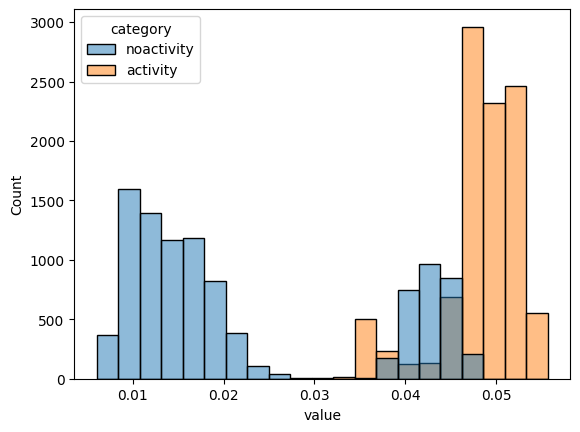

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax1 = plt.subplots(1, 1)

sns.histplot(data=df_full, x='value', hue='category', ax=ax1)

a. Show Visual Proof using Histograms to show why that Threshold is the best for the task

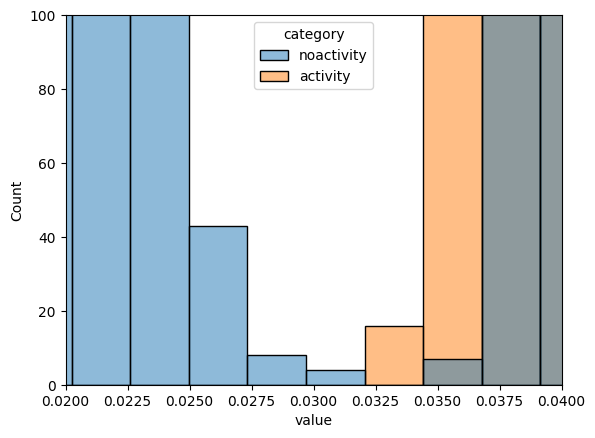

In [213]:
# Shorten range for accuracy
ax1.set_xlim([0.02, 0.04])
ax1.set_ylim([0, 100])
fig

In [ ]:
threshold = 0.031

# The value in the middle of the normal and anomaly values is between 0.0300 and 0.0325,
# so the threshold must be around 0.031.

tensor(False) tensor(False)


In [ ]:
# Testing the threhold
# import random
# a = random.randint(0,1000)

# print(loss_fn(model(X_noactivity_tensor[a]), X_noactivity_tensor[a]).item())

389

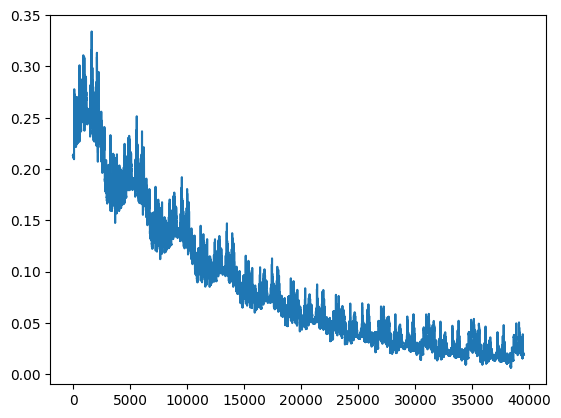

In [218]:
plt.plot(loss_values)
plt.show()

# 3. Answer the Following Questions at the end of the Python Notebook

a. Try to recreate the model, but use a smaller latent vector. What happened in this case and why do you think this happened?

Using a smaller latent vector (3) led to significant increase of counts of anomalies (activity), significant decrease of counts for normal values (not activity), and decrease of loss values of anomalies, shifting them in the graph near zero. A possible reason for this is the small latent vector means less information is captured from the input data. Therefore, reconstructing the latent vector becomes makes the model more prone to error, resulting to a higher count of the instances being flagged as anomalies. Also, the small latent vector means excessive compression, leading to the model failing to differentiate anomalies and identifying minimal differences from reconstruction. This is what caused the low loss values of anomalies.

In [219]:
# Use latent vector of size 3
class AnomalyDetectionSmallLatent(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Linear(31, 3)

    self.decoder = nn.Linear(3, 31)

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed

model = AnomalyDetectionSmallLatent()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

X_activity_tensor = torch.tensor(X_activity.values).to(torch.float32)
X_noactivity_tensor = torch.tensor(X_noactivity.values).to(torch.float32)

loss_values = []
model.train()

for epoch in range(epochs):
  for i in range(0, len(X_noactivity), batch_size):
    reconst = model(X_noactivity_tensor[i:i+batch_size])
    loss = loss_fn(reconst, X_noactivity_tensor[i:i+batch_size])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_values.append(loss.item())

    print('Epoch{0} Step {1}: Loss - {2}'.format(epoch+1, i, loss), end='\r')

<Axes: xlabel='value', ylabel='Count'>

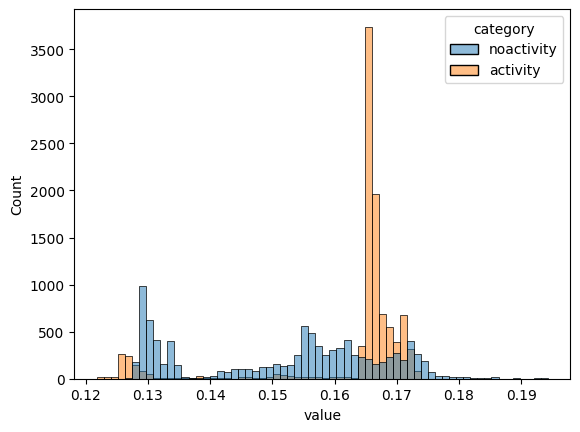

In [220]:
activity_loss_small = []

for i in range(0, sample_size):
  with torch.no_grad():
    reconstructed = model(X_activity_tensor[i])
    loss = loss_fn(reconstructed,X_activity_tensor[i])

    activity_loss_small.append(loss.item())

noactivity_loss_small = []

for i in range(0, sample_size):
  with torch.no_grad():
    reconstructed = model(X_noactivity_tensor[i])
    loss = loss_fn(reconstructed,X_noactivity_tensor[i])

    noactivity_loss_small.append(loss.item())

df_activity_small = pd.DataFrame(activity_loss_small, columns=['value'])
df_activity_small['category'] = 'activity'

df_noactivity_small = pd.DataFrame(noactivity_loss_small, columns=['value'])
df_noactivity_small['category'] = 'noactivity'

df_full_small = pd.concat([df_noactivity_small, df_activity_small])
# df_full.head()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax2 = plt.subplots(1, 1)
sns.histplot(data=df_full_small, x='value', hue='category')

b. Try to recreate the model where the latent vector is bigger in size than the input
vector. What happened in this case and why do you think happened?

Using a latent vector of size (1000), which is significantly higher than the input vector(31), surprisingly led to a result that is very similar to the initial graph. A possible explanation for this is the large size of latent vector allowed for more information to be captured from the input vector, so it has more accuracy when classifying the inputs. However, the the extremely large space, it may also tend to pick up all details of the training data and "memorize" them in a way. This can explain the high accuracy of the graph since it is classifying the training data as well. This hinders the model from finding important patterns from the input vector, thus it is good in working with the training data but can hae difficulties with an unfamiliar testing data.

In [225]:
# Use latent vector of size 1000
class AnomalyDetectionBigLatent(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Linear(31, 1000)

    self.decoder = nn.Linear(1000, 31)

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed

model = AnomalyDetectionBigLatent()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

X_activity_tensor = torch.tensor(X_activity.values).to(torch.float32)
X_noactivity_tensor = torch.tensor(X_noactivity.values).to(torch.float32)

loss_values = []
model.train()

for epoch in range(epochs):
  for i in range(0, len(X_noactivity), batch_size):
    reconst = model(X_noactivity_tensor[i:i+batch_size])
    loss = loss_fn(reconst, X_noactivity_tensor[i:i+batch_size])

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_values.append(loss.item())

    print('Epoch{0} Step {1}: Loss - {2}'.format(epoch+1, i, loss), end='\r')

<Axes: xlabel='value', ylabel='Count'>

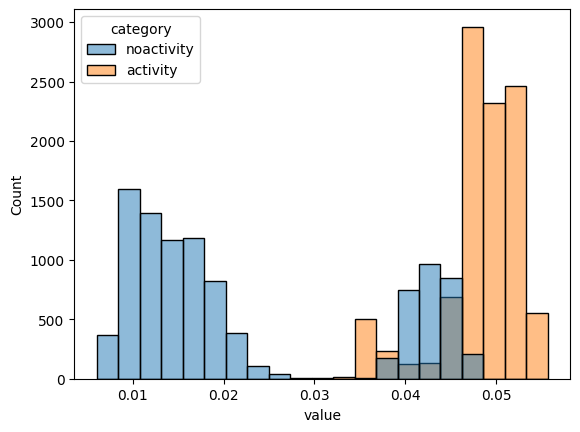

In [ ]:
activity_loss_big = []

for i in range(0, sample_size):
  with torch.no_grad():
    reconstructed = model(X_activity_tensor[i])
    loss = loss_fn(reconstructed,X_activity_tensor[i])

    activity_loss_big.append(loss.item())

noactivity_loss_big = []

for i in range(0, sample_size):
  with torch.no_grad():
    reconstructed = model(X_noactivity_tensor[i])
    loss = loss_fn(reconstructed,X_noactivity_tensor[i])

    noactivity_loss_big.append(loss.item())

df_activity_big = pd.DataFrame(activity_loss, columns=['value'])
df_activity_big['category'] = 'activity'

df_noactivity_big = pd.DataFrame(noactivity_loss, columns=['value'])
df_noactivity_big['category'] = 'noactivity'

df_full_big = pd.concat([df_noactivity, df_activity])
# df_full.head()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax3 = plt.subplots(1, 1)
sns.histplot(data=df_full_big, x='value', hue='category')